# Locate parameters

This notebook can help to find optimal locate parameters.

Run each cell in order, as described.

Note that on a large enough dataset, no single value will work for every single video.

A given set of parameters should be tried on as many videos as possible to find a compromise.

False positives during the locate phase are fairly easy to discard downstream.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp

from mint.utils import get_file_list
from mint.input import get_frames
from mint.denoising import filtering

import ipywidgets as widgets

### Get file list

In [2]:
pl, nl = get_file_list(r'/path/to/folder', extension='tif')

### Get random file from the list

In [3]:
id = int(np.random.rand()*len(pl))
frames = get_frames(pl[id])
frames = frames.astype(np.float64)

### Or import a specific video

In [5]:
path = r'/path/to/video.tif'
frames = get_frames(path)
frames = frames.astype(np.float64)

### Display the first frame

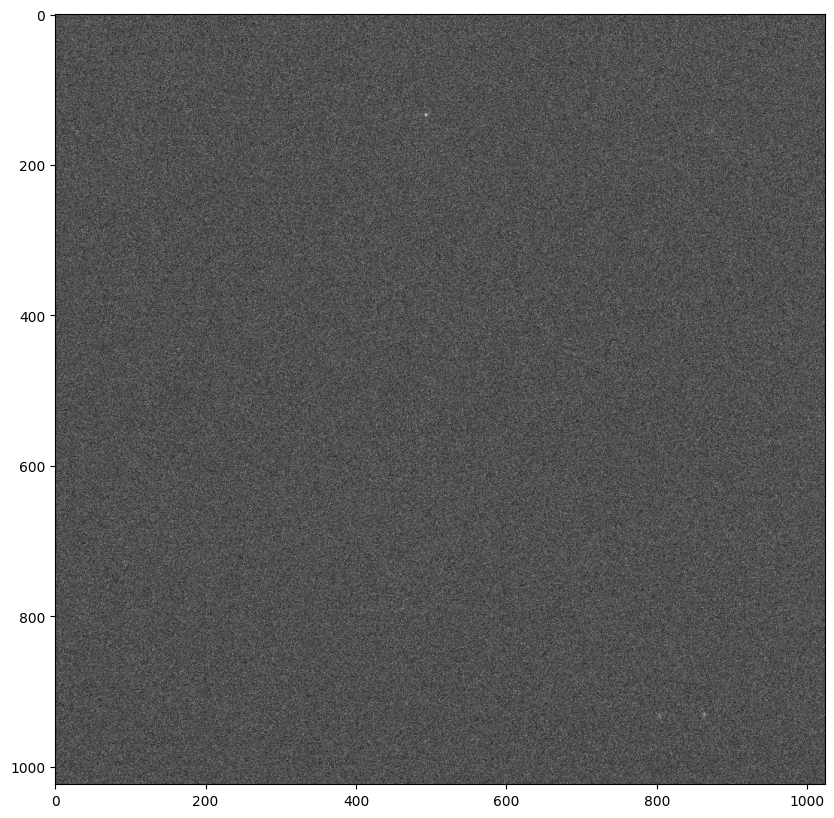

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(frames[0], cmap='gray')

### Visualize possible filters

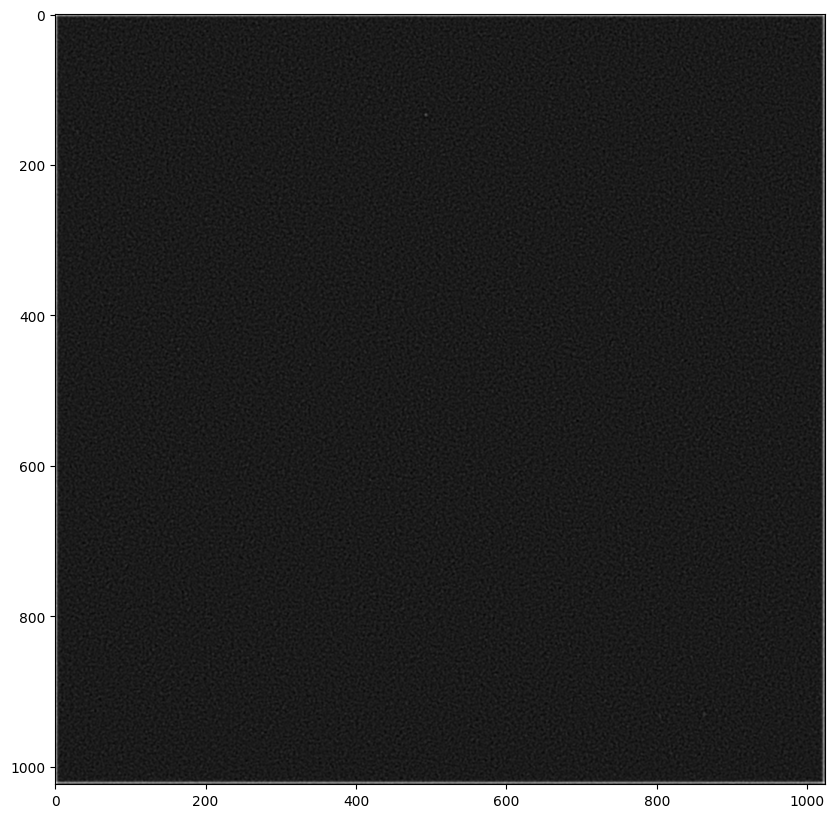

In [5]:
f_frame = filtering(frames[0].copy(), settings={'tophat': False, 'wavelet': True}, parameters={'separation':6})
plt.figure(figsize=(10, 10))
plt.imshow(f_frame[0], cmap='gray')

### Load interactive widgets

In [6]:
style = {'description_width': 'initial'}

minmass_lower = widgets.IntText(description='Minmass, lower bound', style=style, value=0)
minmass_upper = widgets.IntText(description='Minmass, upper bound', style=style, value=100)
diameter_lower = widgets.IntText(description='Diameter, lower bound', style=style, value=0)
diameter_upper = widgets.IntText(description='Diameter, upper bound', style=style, value=20)
separation_lower = widgets.IntText(description='Separation, lower bound', style=style, value=0)
separation_upper = widgets.IntText(description='Separation, upper bound', style=style, value=20)

minmass_range = widgets.IntSlider(description='Minmass',
                                  continuous_update=False,
                                  readout=True,
                                  min=minmass_lower.value,
                                  max=minmass_upper.value,
                                  value=np.mean([minmass_lower.value, minmass_upper.value]))

diameter_range = widgets.IntSlider(description='Diameter',
                                  continuous_update=False,
                                  readout=True,
                                  min=diameter_lower.value,
                                  max=diameter_upper.value,
                                  value=np.mean([diameter_lower.value, diameter_upper.value]))

separation_range = widgets.IntSlider(description='Separation',
                                  continuous_update=False,
                                  readout=True,
                                  min=separation_lower.value,
                                  max=separation_upper.value,
                                  value=np.mean([separation_lower.value, separation_upper.value]))

frame_range = widgets.IntSlider(description='Frame',
                                  continuous_update=False,
                                  readout=True,
                                  min=0,
                                  max=len(frames),
                                  value=0)

def test_locate(index, tophat, wavelet, minmass, diameter, separation):
    if not diameter % 2:
        diameter = diameter + 1

    f_frame = frames[index]

    settings = {'tophat': False,
                'wavelet': False}

    if tophat:
        settings['tophat'] = True
    if wavelet:
        settings['wavelet'] = True

    f_frame = filtering(frames=f_frame.copy(),
                        settings=settings,
                        parameters={'separation':separation})
        
    raw_coordinates = tp.locate(f_frame,
                                minmass=minmass,
                                diameter=diameter,
                                separation=separation,
                                preprocess=False,
                                engine='numba')
    plt.figure(figsize=(10, 10))
    plt.imshow(f_frame[0])
    plt.title("Locate parameters test", fontsize=10)
    plt.xlabel("x (pixels)", fontsize=10)
    plt.ylabel("y (pixels)", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    tp.annotate(raw_coordinates,
                f_frame[0],
                plot_style={'markersize': 10},
                color='red')
    plt.figtext(0.5, 0.01,
                f'Number of particles found :  {len(raw_coordinates)}',
                ha='center')
    plt.show()

def update_bounds(ml, mu, dl, du, sl, su):
    minmass_range.min = ml
    minmass_range.max = mu
    diameter_range.min = dl
    diameter_range.max = du
    separation_range.min = sl
    separation_range.max = su

### Set lower and upper boundaries

In [ ]:
widgets.interact(update_bounds,
                 ml=minmass_lower,
                 mu=minmass_upper,
                 dl=diameter_lower,
                 du=diameter_upper,
                 sl=separation_lower,
                 su=separation_upper)

### Try out parameters

Note that separation must always be an odd integer. If an even number is selected, it will be rounded up.

The wavelet filter will significantly alter the range of intensities, expect a ~10 fold reduction in minmass values.

In [ ]:
widgets.interact(test_locate,
                 index=frame_range,
                 tophat=False,
                 wavelet=False,
                 minmass=minmass_range,
                 diameter=diameter_range,
                 separation=separation_range)